# Makemore part: 3

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Read all the words 
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# Build the volcabulary of the characters and mapping to/from integers 
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)
vocab_size = len(itos)


{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
# Build the dataset
# Training split, dev/validation split, test split 
# 80%, 10%, 10%
# Training set: Used to optimize the parameters of the model
# Dev/ validation set: Used to development of all the hyperparameters of the model like size of the hidden layer, size of the embedding etc.
# test set: evaluate the performance of the model. You should test on test set few times otherwise you might end up overfitting to test set as well. 
block_size = 3 # context length: how many characters do we take to predict the next one?
def build_dataset(words):
    
    X, Y = [], []

    for w in words:
    #     print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
    #         print(''.join(itos[i] for i in context),'------>',itos[ix])
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random 
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
# MLP revisited 
n_embd = 10 # Dimensionality of the character embedding vectors 
n_hidden = 200 # The number of neurons in the hidden layer 


g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size,n_embd), generator=g)
W1 = torch.randn((n_embd * block_size,n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden,vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g)
parameters = [C, W1, b1, W2, b2]

print("Total parameters:", sum(p.nelement() for p in parameters)) # Number of parameters in total
for p in parameters:
    p.requires_grad = True

Total parameters: 11897


In [7]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # Creating a mini batch 
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    # Forward pass
    emb = C[Xtr[ix]] # (32,3,2) # Embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # Concatenate the vectors
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    #Update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -0.1 * p.grad
    # Track status
    if i % 10000 == 0: # Print every once in a while
        print(f'{i:7d}/{max_steps:7d}:{loss.item():.4f}')
    lossi.append(loss.log10().item())
    


      0/ 200000:27.8817
  10000/ 200000:2.8263
  20000/ 200000:2.5130
  30000/ 200000:2.8010
  40000/ 200000:2.0541
  50000/ 200000:2.6152
  60000/ 200000:2.3549
  70000/ 200000:2.0835
  80000/ 200000:2.2652
  90000/ 200000:2.2635
 100000/ 200000:2.0810
 110000/ 200000:2.5915
 120000/ 200000:1.9485
 130000/ 200000:2.7237
 140000/ 200000:2.2815
 150000/ 200000:2.2346
 160000/ 200000:1.9754
 170000/ 200000:1.8894
 180000/ 200000:2.3446
 190000/ 200000:1.8712


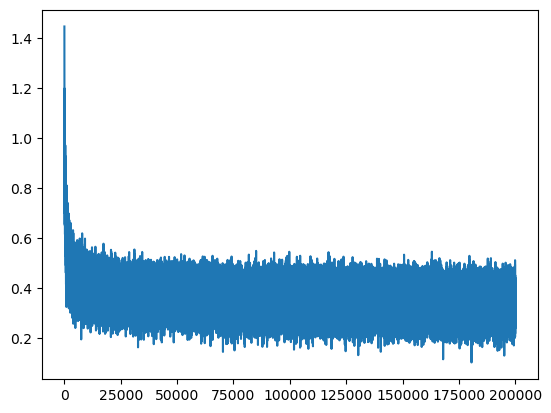

In [8]:
plt.plot(lossi)

In [9]:
@torch.no_grad() # This decorator disables gradient tracking it almost like all the tensors created in the function has requires_grad = falls. 
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': {Xdev, Ydev},
        'test': {Xte, Yte},
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1) # Concatenate the vectors
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train')
split_loss('val')

train 2.187913179397583
val 2.2472822666168213


In [10]:
# Sample from the model 
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size # Initialize with all ...
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1,-1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))
        
        
        

carmahzato.
heri.
kemy.
khem.
cassanden.
jazon.
nadelyah.
jareei.
nellara.
chriivon.
nechysham.
edin.
quinthonor.
emmarebi.
wazthon.
jaryxi.
jayenni.
sai.
eddeci.
aketzeley.


## What is wrong here?
- At the initialization of this network, the loss is too high (around 26). It shows the network is poorly configured at the initialization. 
- With training of neural nets you have a rough idea of what loss to expect at initialization. 
- For this particular case, we know that at the start all the 27 characters are equally likely to come next for any training example. So we would expect uniform probability distribution in the beginning. So the probability of any character should be 1/27 in our example. In the following cell what loss we should expect at the initialization is calculated. 


In [11]:
-torch.tensor(1/27.0).log()

tensor(3.2958)

### Fixing initialization:
- With our current initialization, the neural net is creating probability distribution that is all messed up. Some characters are assigned very high probability whereas some are assigned very low probability. So the network is very confidently wrong. Thats what makes it record very high loss. 
- In the following cells, we are rectifying this issue. The current values of logits are very high. We are trying make them come close to zero.
- The first step is to make b2 zero as that is adding in logits calculation. 
- Second is to scale down w2. 

In [12]:
n_embd = 10 # Dimensionality of the character embedding vectors 
n_hidden = 200 # The number of neurons in the hidden layer 


g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size,n_embd), generator=g)
W1 = torch.randn((n_embd * block_size,n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden,vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0
parameters = [C, W1, b1, W2, b2]

print("Total parameters:", sum(p.nelement() for p in parameters)) # Number of parameters in total
for p in parameters:
    p.requires_grad = True

Total parameters: 11897


In [13]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # Creating a mini batch 
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    # Forward pass
    emb = C[Xtr[ix]] # (32,3,2) # Embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # Concatenate the vectors
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    #Update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -0.1 * p.grad
    # Track status
    if i % 10000 == 0: # Print every once in a while
        print(f'{i:7d}/{max_steps:7d}:{loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    


      0/ 200000:3.3221
  10000/ 200000:2.1900
  20000/ 200000:2.4196
  30000/ 200000:2.6067
  40000/ 200000:2.0601
  50000/ 200000:2.4988
  60000/ 200000:2.3902
  70000/ 200000:2.1344
  80000/ 200000:2.3369
  90000/ 200000:2.1299
 100000/ 200000:1.8329
 110000/ 200000:2.4014
 120000/ 200000:1.8665
 130000/ 200000:2.4811
 140000/ 200000:2.3315
 150000/ 200000:2.2080
 160000/ 200000:1.9675
 170000/ 200000:1.9001
 180000/ 200000:2.1144
 190000/ 200000:1.8790


#### Note:
- We will now not be getting the hockey shape graph. This it true for any neural network we train. 

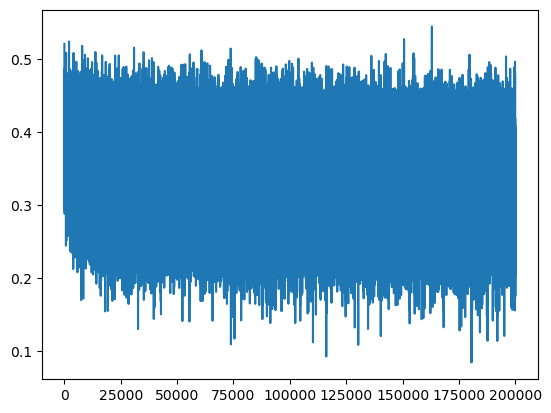

In [14]:
plt.plot(lossi)

In [15]:
@torch.no_grad() # This decorator disables gradient tracking it almost like all the tensors created in the function has requires_grad = falls. 
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': {Xdev, Ydev},
        'test': {Xte, Yte},
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1) # Concatenate the vectors
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train')
split_loss('val')

train 2.1578962802886963
val 2.229379653930664


### Note
- As we can see, we are getting slightly better results than the previous iteration because we are spending more time actually training the model rather than speding training iterations on squashing the weights initially. 

### Problem with h:
- Now as we resolved the initialization problem, there are still some issues with the value of h. 
- Many elements of h are 1 or -1. 
- tanh is a squashing function, meaning it will squash the input values between 1 and -1. 
- See the histogram below. 
- This will create a problem during back propogation. If the value is 1 or -1, we are killing the gradient by making it 0 (Check the equation of backward pass for the tanh layer). So we are effectively making the backpropogation through this tanh layer. Intutively as well the value of slope near the end of tanh is almost zero. 
- To futher assess the problem. We are also plotting the absolute values of h as a figure to show that how many times it is greater than 0.99. White parts shows whenever the condition is true. 
- In the figure, if any one column is entirely white then that corresponds to a dead neuron out of the 200 neurons. These neurons will never learn as the gradient never passes through them.
- This is not just true for tanh but true for a lot of other non-linearities. 
- This dead neuron can happen during the intialization stage when the weights and biases are such that they are not in the learning range and the neurons are dead.
- But this can also happen during the learning stage (optimization stage) as well. When the gradient is so high (maybe due to very high learning rate) that it will knock that neuron out of the data manifold, and from then no example will ever activate the neuron. They will like dead brain cells (permanent brain damage).  
- Some non linearities like leaky relu doesnt suffer this issue. 

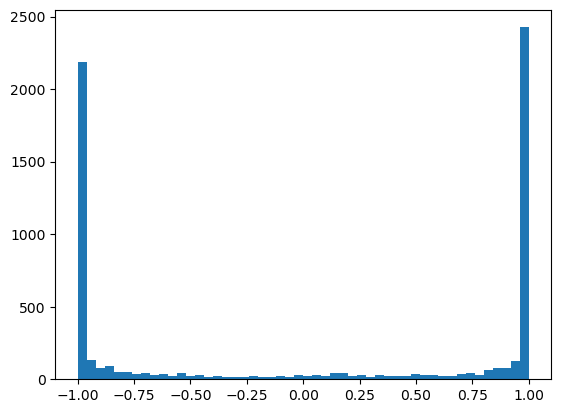

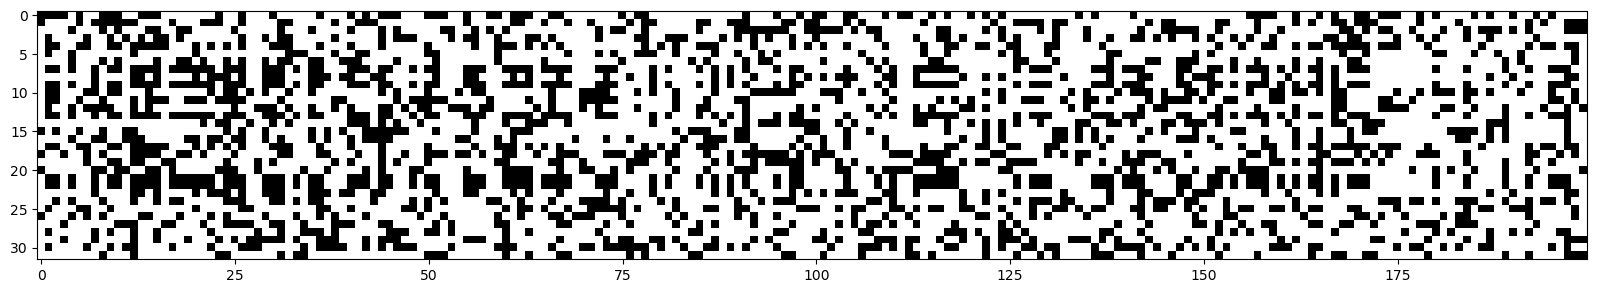

In [16]:
plt.hist(h.view(-1).tolist(), 50)
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

### Fixing the issue with tanh
- We will use the similar approach that we used to resolve the issue with initialization. 
- We will scale down the effect of W1 and b1 to get smaller values for hpreact 

In [17]:
# Fixing the issue with tanh
n_embd = 10 # Dimensionality of the character embedding vectors 
n_hidden = 200 # The number of neurons in the hidden layer 


g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size,n_embd), generator=g)
W1 = torch.randn((n_embd * block_size,n_hidden), generator=g) * 0.2
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden,vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0
parameters = [C, W1, b1, W2, b2]

print("Total parameters:", sum(p.nelement() for p in parameters)) # Number of parameters in total
for p in parameters:
    p.requires_grad = True

Total parameters: 11897


In [18]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # Creating a mini batch 
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    # Forward pass
    emb = C[Xtr[ix]] # (32,3,2) # Embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # Concatenate the vectors
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    #Update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -0.1 * p.grad
    # Track status
    if i % 10000 == 0: # Print every once in a while
        print(f'{i:7d}/{max_steps:7d}:{loss.item():.4f}')
    lossi.append(loss.log10().item())
    break
    


      0/ 200000:3.3135


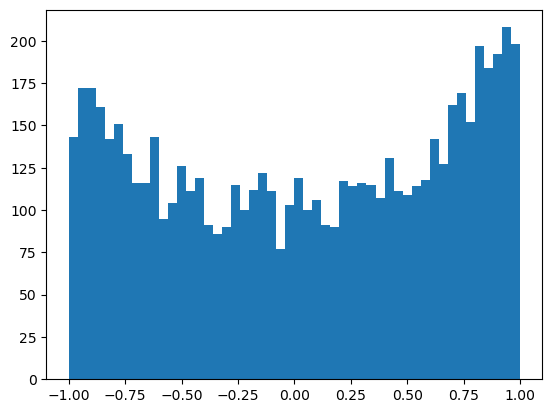

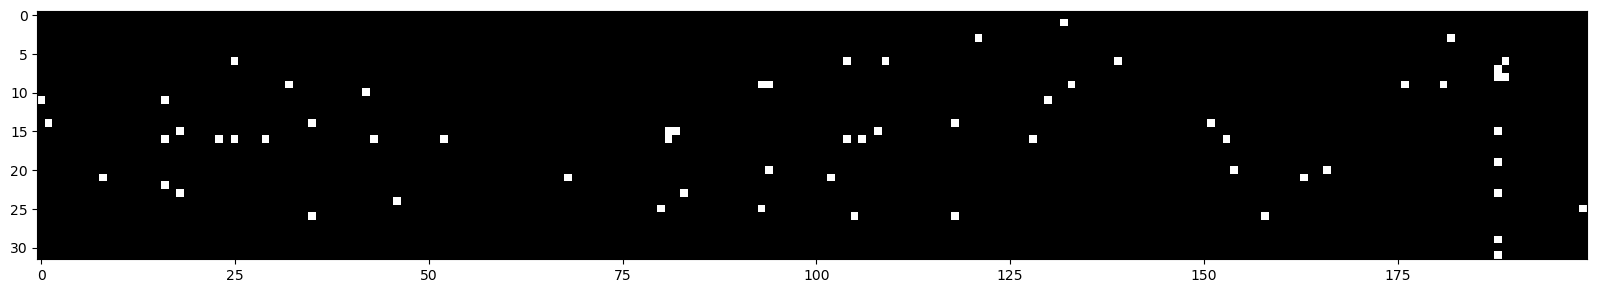

In [19]:
plt.hist(h.view(-1).tolist(), 50)
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

- This seems to be a nice distribution. 
- Now training the full model

In [20]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # Creating a mini batch 
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    # Forward pass
    emb = C[Xtr[ix]] # (32,3,2) # Embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # Concatenate the vectors
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    #Update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -0.1 * p.grad
    # Track status
    if i % 10000 == 0: # Print every once in a while
        print(f'{i:7d}/{max_steps:7d}:{loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    


      0/ 200000:3.2465
  10000/ 200000:1.9043
  20000/ 200000:1.9004
  30000/ 200000:1.9465
  40000/ 200000:2.1656
  50000/ 200000:2.0071
  60000/ 200000:2.0826
  70000/ 200000:2.4228
  80000/ 200000:2.3109
  90000/ 200000:2.1167
 100000/ 200000:2.2166
 110000/ 200000:1.9169
 120000/ 200000:2.3950
 130000/ 200000:2.1029
 140000/ 200000:1.9980
 150000/ 200000:2.4943
 160000/ 200000:2.2493
 170000/ 200000:1.7603
 180000/ 200000:2.0242
 190000/ 200000:2.0386


In [21]:
split_loss('train')
split_loss('val')

train 2.1146559715270996
val 2.1880686283111572


### Notes:
- The results are better than what we obtain last time by just fixing the initialization. 
- We have been working with one layer MLP neural network so the optimization problem is easy and quite forgiving. This is not the case in general though. 
- With deeper networks the things can get complicated.
- We need a structured way of intializing and coming up with the multipliers for weights and biases. 
- Lets do an experiment. Here in the following cell, we are multiplying two gaussians and finding the mean and standard deviation of the resulting gaussian. 

tensor(0.0114) tensor(0.9971)
tensor(-0.0116) tensor(3.1305)


(array([7.07816913e-06, 0.00000000e+00, 3.53908457e-05, 4.24690148e-05,
        8.49380296e-05, 1.62797890e-04, 1.84032397e-04, 3.39752118e-04,
        8.49380296e-04, 1.40855566e-03, 2.09513806e-03, 3.36213034e-03,
        5.70500432e-03, 8.65660085e-03, 1.25920629e-02, 1.96560757e-02,
        2.94168709e-02, 4.15488528e-02, 5.79985179e-02, 7.64371484e-02,
        9.52367657e-02, 1.14475229e-01, 1.28192721e-01, 1.35129327e-01,
        1.32659046e-01, 1.21815291e-01, 1.07935001e-01, 8.83992543e-02,
        6.97907476e-02, 5.14512114e-02, 3.66436816e-02, 2.52832201e-02,
        1.74476869e-02, 1.18276206e-02, 7.16310716e-03, 4.26813599e-03,
        3.16394160e-03, 1.76954228e-03, 9.83865509e-04, 7.07816913e-04,
        3.04361273e-04, 2.19423243e-04, 4.95471839e-05, 7.07816913e-05,
        1.41563383e-05, 2.83126765e-05, 0.00000000e+00, 1.41563383e-05,
        0.00000000e+00, 7.07816913e-06]),
 array([-16.83701897, -16.1306216 , -15.42422424, -14.71782688,
        -14.01142952, -13.3050

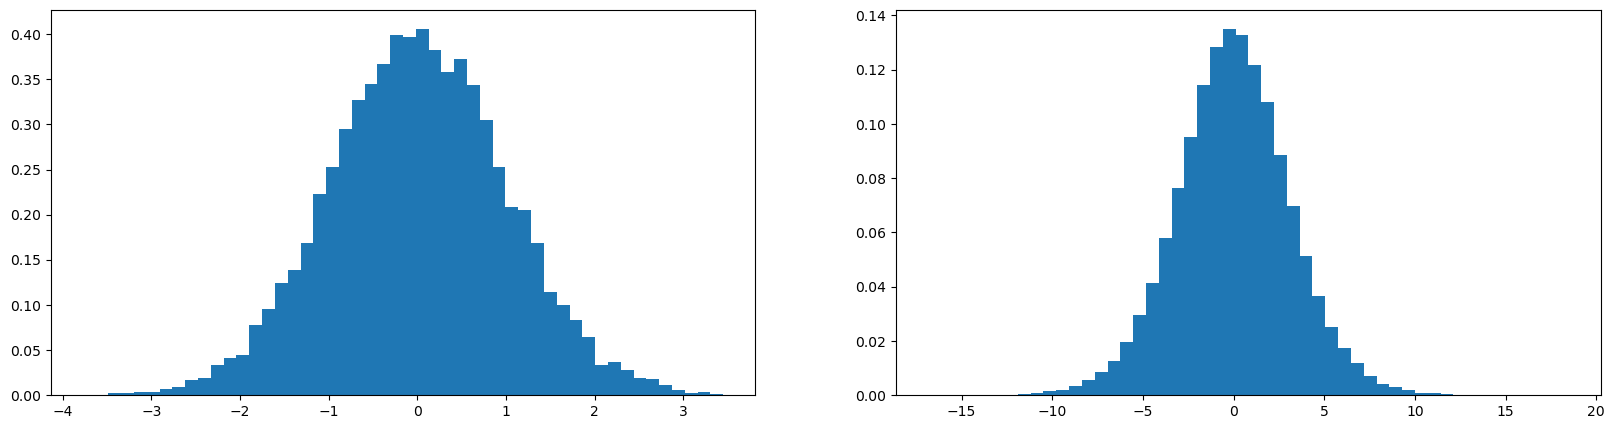

In [22]:
x = torch.randn(1000,10)
w = torch.randn(10,200)
y = x @ w
print(x.mean(), x.std())
print(y.mean(),y.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)

### Note:
- We can see that the standard deviation increases after multiplication. 
- Lets multiply w by a small number and check the resulting standard deviation.

tensor(0.0011) tensor(1.0167)
tensor(0.0001) tensor(0.6437)


(array([7.39530547e-05, 3.69765274e-05, 1.10929582e-04, 1.10929582e-04,
        2.58835692e-04, 1.84882637e-04, 6.28600965e-04, 1.18324888e-03,
        1.77487331e-03, 2.47742733e-03, 4.06741801e-03, 7.02554020e-03,
        1.14627235e-02, 1.72310618e-02, 2.85089026e-02, 4.11178984e-02,
        6.23794017e-02, 8.91134310e-02, 1.32523874e-01, 1.79225228e-01,
        2.37352329e-01, 3.19144408e-01, 4.11142008e-01, 4.97814988e-01,
        5.78128005e-01, 6.49603633e-01, 6.78556254e-01, 6.51045717e-01,
        6.10926185e-01, 5.14824191e-01, 4.35842328e-01, 3.41884972e-01,
        2.55618734e-01, 1.94607464e-01, 1.39512438e-01, 9.77289618e-02,
        6.68165850e-02, 4.78846029e-02, 3.26132971e-02, 2.04849962e-02,
        1.32745733e-02, 7.94995339e-03, 5.65740869e-03, 3.10602830e-03,
        1.81184984e-03, 1.07231929e-03, 7.76507075e-04, 3.32788746e-04,
        1.84882637e-04, 1.10929582e-04]),
 array([-3.60093856, -3.46571764, -3.33049672, -3.1952758 , -3.06005488,
        -2.92483397, 

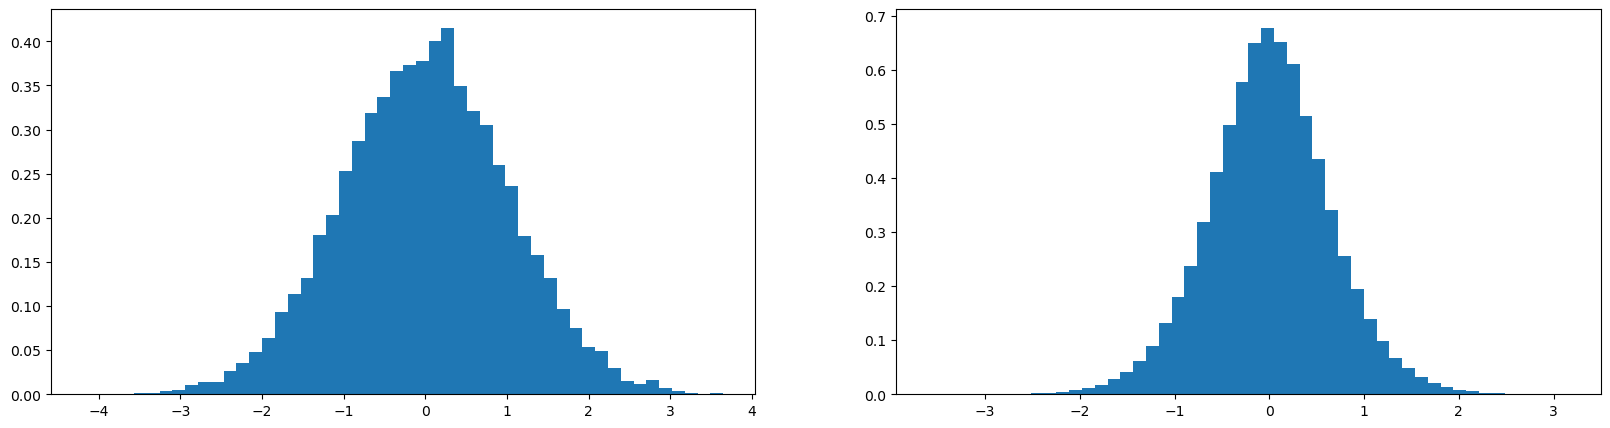

In [23]:
x = torch.randn(1000,10)
w = torch.randn(10,200) * 0.2
y = x @ w
print(x.mean(), x.std())
print(y.mean(),y.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)

## Note:
- Now what do we multiply w with such that standard deviation remains 1? 
- The correct answer is to divide w by the square root of fan in (number of input elements). 

tensor(0.0009) tensor(0.9891)
tensor(-0.0019) tensor(0.9891)


(array([4.71489540e-05, 7.07234311e-05, 0.00000000e+00, 2.12170293e-04,
        1.41446862e-04, 4.24340586e-04, 5.18638494e-04, 9.42979081e-04,
        1.74451130e-03, 2.19242636e-03, 3.91336319e-03, 6.29438536e-03,
        8.91115231e-03, 1.42625586e-02, 2.25607745e-02, 3.20141398e-02,
        4.90584867e-02, 7.15721122e-02, 1.00073655e-01, 1.38900819e-01,
        1.88077178e-01, 2.36286983e-01, 2.99018667e-01, 3.57954859e-01,
        4.17527563e-01, 4.38980337e-01, 4.40182635e-01, 4.09394368e-01,
        3.51801921e-01, 2.90036791e-01, 2.35815494e-01, 1.75606279e-01,
        1.29023113e-01, 9.39207165e-02, 6.35567900e-02, 4.64888687e-02,
        3.15897992e-02, 2.09812845e-02, 1.30366858e-02, 8.03889666e-03,
        5.37498076e-03, 3.15897992e-03, 2.07455398e-03, 1.27302176e-03,
        7.30808788e-04, 4.00766109e-04, 3.30042678e-04, 1.41446862e-04,
        1.41446862e-04, 9.42979081e-05]),
 array([-5.49689388, -5.2848001 , -5.07270632, -4.86061254, -4.64851875,
        -4.43642497, 

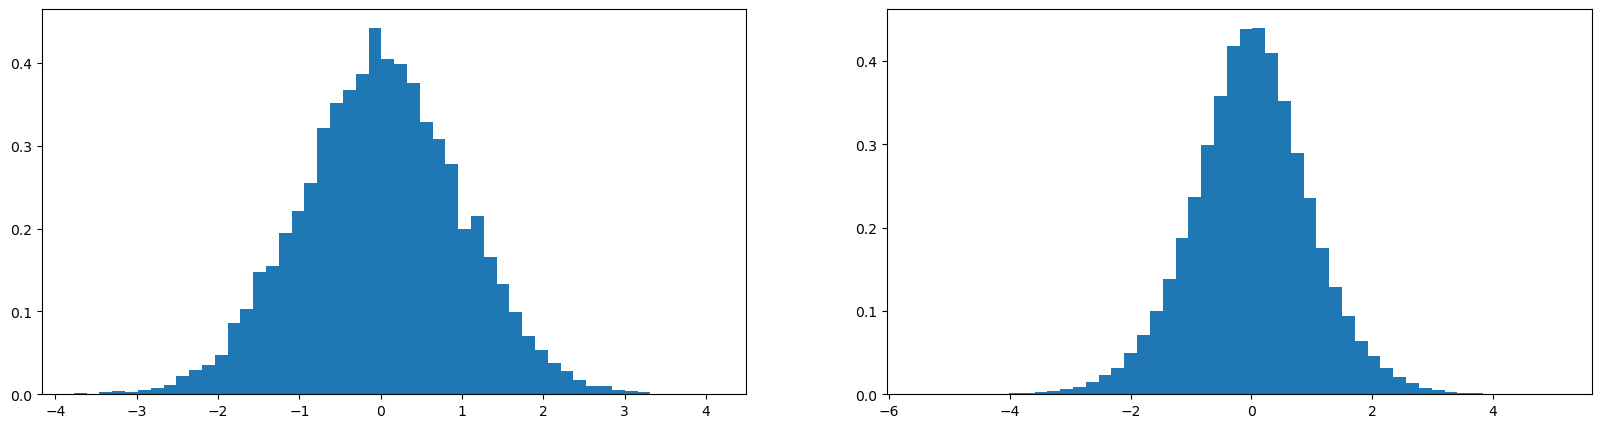

In [24]:
x = torch.randn(1000,10)
w = torch.randn(10,200) / 10**0.5
y = x @ w
print(x.mean(), x.std())
print(y.mean(),y.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)

## Note:
- You should Kaiming initialization (there is a paper). It is also implemented in Pytorch.
- This is the most common way of initializing the neuran networks now. Zero mean and unit standard deviation. 
- About the time this Kaiming paper came out, you had to be really careful the activations and the gradients, the gains, the nonlinearity. Everything was very fragile and finicky if the neural net was very deep. But there are many modern, that made everything very stable and well behaved and it has become less important to intialize these networks exactly right. These modern developments are residual connections, the use of various normalization layers like batch normalization, layer normalization, also much better optimizers like RMS Prop, ADAM. 
- Using Kaiming initialization in our example
- Kaiming normalization can be used for both activations and gradients. However, the paper shows that it doesnt affect the results too much by applying it to the gradients so by default it is applied to the activations. 


In [25]:
# Fixing the issue with tanh
n_embd = 10 # Dimensionality of the character embedding vectors 
n_hidden = 200 # The number of neurons in the hidden layer 


g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size,n_embd), generator=g)
W1 = torch.randn((n_embd * block_size,n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden,vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0
parameters = [C, W1, b1, W2, b2]

print("Total parameters:", sum(p.nelement() for p in parameters)) # Number of parameters in total
for p in parameters:
    p.requires_grad = True

Total parameters: 11897


In [26]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # Creating a mini batch 
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    # Forward pass
    emb = C[Xtr[ix]] # (32,3,2) # Embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # Concatenate the vectors
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    #Update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -0.1 * p.grad
    # Track status
    if i % 10000 == 0: # Print every once in a while
        print(f'{i:7d}/{max_steps:7d}:{loss.item():.4f}')
    lossi.append(loss.log10().item())
    

      0/ 200000:3.3179
  10000/ 200000:2.1910
  20000/ 200000:2.3270
  30000/ 200000:2.5396
  40000/ 200000:1.9468
  50000/ 200000:2.3331
  60000/ 200000:2.3852
  70000/ 200000:2.1173
  80000/ 200000:2.3159
  90000/ 200000:2.2010
 100000/ 200000:1.8591
 110000/ 200000:2.3167
 120000/ 200000:1.9626
 130000/ 200000:2.2936
 140000/ 200000:2.1852
 150000/ 200000:2.2831
 160000/ 200000:1.7577
 170000/ 200000:1.7677
 180000/ 200000:2.1656
 190000/ 200000:1.9137


In [27]:
split_loss('train')
split_loss('val')

train 2.1176769733428955
val 2.1908650398254395


## Batch Normalization
- The idea of batch normalization is to make the hidden states gaussian with zero mean and unit standard deviation at initialization. This operation is completely differentiable. 
- One point to note is that we want these hiddle state to be gaussian with zero mean and unit standard deviation only at initalization. During the training, we want them to move around as they are adjusted by the gradients. That is done in batch normalization using bngain and bnbias values. The values of bngain and bnbias change during backpropogation. 

In [28]:
# Batch Normalization
n_embd = 10 # Dimensionality of the character embedding vectors 
n_hidden = 200 # The number of neurons in the hidden layer 


g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size,n_embd), generator=g)
W1 = torch.randn((n_embd * block_size,n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden,vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0


bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]

print("Total parameters:", sum(p.nelement() for p in parameters)) # Number of parameters in total
for p in parameters:
    p.requires_grad = True

Total parameters: 12297


In [29]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # Creating a mini batch 
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    # Forward pass
    emb = C[Xb] # (32,3,2) # Embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # Concatenate the vectors
    hpreact = embcat @ W1 + b1 #b1 Not needed because of batch normalization.
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    #Update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    # Track status
    if i % 10000 == 0: # Print every once in a while
        print(f'{i:7d}/{max_steps:7d}:{loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    

      0/ 200000:3.3147
  10000/ 200000:2.1984
  20000/ 200000:2.3375
  30000/ 200000:2.4359
  40000/ 200000:2.0119
  50000/ 200000:2.2595
  60000/ 200000:2.4775
  70000/ 200000:2.1020
  80000/ 200000:2.2788
  90000/ 200000:2.1862
 100000/ 200000:1.9474
 110000/ 200000:2.3010
 120000/ 200000:1.9837
 130000/ 200000:2.4523
 140000/ 200000:2.3839
 150000/ 200000:2.1987
 160000/ 200000:1.9733
 170000/ 200000:1.8668
 180000/ 200000:1.9973
 190000/ 200000:1.8347


### Note:
- We also need to do batch normalization during the test time. 

### Note:
- Batch normalization is easy to implement in very deep neural nets compared to the previous approach. Its easy to sprinkle batch normalization layers through out the neural network.
- The effectiveness of Batchnormalization is difficult to observe in this example as the network is very small. 
- Batch normalization provides great stability to training process. 
- But stability comes at a cost, as we are doing batch normalization and finding meaning and standard deviation of the batch of the examples in a hidden state of a single example we are kind of mathematically coupling these batch of examples. So the hidden states or the logits are not only the function of a single example but a function of the batch of the examples. This seems to be a bug but it turns out to be good in training as side effect. It acts like a regularizer. It is adding entropy in a particular example and making harder for neural nets to overfit. 
- This coupling also affects the inference stage. As we are using batch normalized h values are coupled with all the examples in the batches. To solve this issue, we will have a step after training, that calculates the batchnorm mean and standard deviation a single time over the training set. And we use those values to calculate h. Refer the following cells. 

In [30]:
# Calibrate the batch norm at the end of training 

with torch.no_grad():
    # Pass the training set through 
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [31]:
@torch.no_grad() # This decorator disables gradient tracking it almost like all the tensors created in the function has requires_grad = falls. 
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': {Xdev, Ydev},
        'test': {Xte, Yte},
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1) # Concatenate the vectors
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train')
split_loss('val')

train 2.0668270587921143
val 2.104926586151123


### Note:
- The same mean and standard deviations can be calculated in running manner. 


In [32]:
@torch.no_grad() # This decorator disables gradient tracking it almost like all the tensors created in the function has requires_grad = falls. 
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': {Xdev, Ydev},
        'test': {Xte, Yte},
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1) # Concatenate the vectors
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train')
split_loss('val')

train 2.066591501235962
val 2.1050572395324707


## Note:
- When we are using batch normalization then the bias term becomes useless as we are calulating mean and then subtracting it. If you check b1.grad that would be zero.

## Additional notes on batch normalization
- Batch normalization can be sprinkled across the neural network but generally we add it after the layers that have multiplications like linear layer or convolutional layers. 